In [ ]:
import torch
import numpy as np
from sklearn.datasets import load_breast_cancer
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.special import comb



(569, 30)
torch.Size([379, 30]) torch.Size([95, 30]) torch.Size([95, 30])


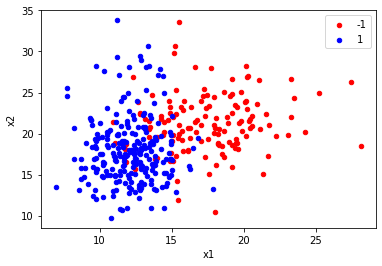

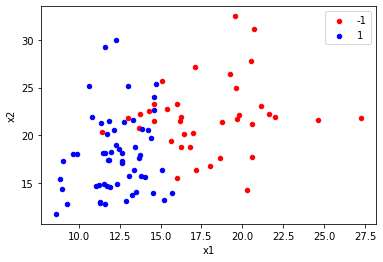

In [ ]:
data = load_breast_cancer()
X_train = data['data']
Y_train = data['target']
print(X_train.shape)
X = torch.FloatTensor(X_train)
labels = torch.FloatTensor(Y_train)
labels = torch.where(labels == 0, -1, 1);


X_train, X_test, Y_train, Y_test = train_test_split(X, labels,test_size=(1-5/6), random_state=73)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,test_size=(1-4/5), random_state=73)

print(X_train.shape, X_test.shape, X_val.shape)
df = pd.DataFrame(dict(x1=X_train[:, 0], x2=X_train[:, 1], y=Y_train))
colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('y')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x1', y='x2', label=key, color = colors[key])
plt.show()

df = pd.DataFrame(dict(x1=X_test[:, 0], x2=X_test[:, 1], y=Y_test))
colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('y')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x1', y='x2', label=key, color = colors[key])
n_input_dim = X_train.shape[1]

plt.show()

**LinearSVM**

In [ ]:
Y_train = torch.where(Y_train == 0, -1, 1)
Y_test = torch.where(Y_test == 0, -1, 1)
Y_val = torch.where(Y_val == 0, -1, 1)
print(Y_train.shape, Y_test.shape, Y_val.shape)
X_train = X_train.float()
X_test = X_test.float()
X_val = X_val.float()
print(X_train.shape, X_test.shape, X_val.shape)

class Generic_SVM_Loss(nn.modules.Module):    
    def __init__(self):
        super(Generic_SVM_Loss,self).__init__()
    def forward(self, outputs, labels):
        return torch.max(torch.zeros_like(labels), 1-labels*outputs).mean()

def hinge_loss(x, y):
    return torch.max(torch.zeros_like(y), 1-y*x).mean()

In [ ]:
#def poly(X, const,pow):
#   return torch.pow(torch.matmul(X.t(),X) + const,pow)

def poly(X, const,pow):
    k = torch.zeros([X.size(0), int(comb(X.size(1) + pow, pow ))])
    for i in range (X.size(1)):
      k[:,i] = X[:,i] ** pow
    
    for i in range(X.size(1)):
      for j in range(i+1,X.size(1)):
        k[:,X.size(1) + i] = X[:,i] * X[:,j] 
    print(k.size())
    return k

def rbf(X, k, gamma):
    return torch.exp(-gamma*(((X[:,None])-k)**2).sum(dim=2))


class Model(torch.nn.Module):
    def __init__(self, X, labels, kernelType, featureDim1 = 1, featureDim2 = 1, gamma = 1, pow = 2):
        super().__init__()
        self.X = X;
        self.labels = labels
        self.kernelType = kernelType
  
        self.k = None
        if(kernelType == 'linear'):
          self.k = self.X 
          self.linearLayer = torch.nn.Linear(featureDim1, 1);
        elif(kernelType == 'rbf'):
          self.k = self.X.repeat(self.X.size(0), 1, 1)
          self.k = rbf(self.X, self.k, 1) 
          self.gamma = torch.nn.Parameter(torch.FloatTensor([gamma]),
                                                  requires_grad=True)
          self.linearLayer = torch.nn.Linear(X.size(0), 1);
        elif(kernelType == 'poly'):
          self.k = poly(X,1,2)
          self.linearLayer = torch.nn.Linear(int(comb(X.size(1) + 2, 2 )), 1);


    def forward(self, X):
        return self.linearLayer(self.k);
        

In [ ]:

#Criteria
svm_loss_criteria_linear = torch.nn.BCELoss()
svm_loss_criteria_rbf = torch.nn.BCELoss()
svm_loss_criteria_poly = torch.nn.BCELoss()


In [ ]:
##Model
polyModel = Model(X_train, Y_train, 'poly', X.size(0), 1, 1,3)
linearModel = Model(X_train, Y_train, 'linear', X.size(1), 1)
rbfModel = Model(X_train, Y_train, 'rbf', X.size(0), 1,)


torch.Size([379, 496])


In [ ]:
#Optimizers
polyOptim = torch.optim.SGD(polyModel.parameters(), lr=0.01)
linearOptim = torch.optim.SGD(linearModel.parameters(), lr=0.01)
rbfOptim = torch.optim.SGD(rbfModel.parameters(), lr=0.01)

In [ ]:
#Accuracy Metric
def accuracy(X, y_real, apply):
    output = apply(X)
    predicted = output.data >= 0
    y_r = torch.unsqueeze(y_real,dim = 1)
    print(torch.count_nonzero(torch.eq(predicted, y_r)),X.size(0))

In [ ]:
print('Linear Accuracy') 
accuracy(X_train, Y_train, linearModel)
print('Poly Accuracy') 
accuracy(X_train, Y_train, polyModel)
print('RBF Accuracy')
accuracy(X_train, Y_train, rbfModel)

Linear Accuracy
tensor(240) 379
Poly Accuracy
tensor(6) 379
RBF Accuracy
tensor(123) 379


In [ ]:
for i in range(5000):
    linearOptim.zero_grad();
    output = linearModel(X_train);
    loss = hinge_loss(output,Y_train)
    loss.backward()
    linearOptim.step();
    if(i % 500 == 0):
        print(i, loss.item(), 'linear')
        accuracy(X_train, Y_train, linearModel)
print('---------------------------------------')
for i in range(5000):
    rbfOptim.zero_grad();
    output = rbfModel(X_train);
    loss = hinge_loss(output, Y_train)
    loss.backward()
    rbfOptim.step();
    if(i % 500 == 0):
        print(i, loss.item(), 'rbf')
        accuracy(X_train, Y_train, rbfModel)
print('---------------------------------------')

for i in range(5000):
    polyOptim.zero_grad();
    output = polyModel(X_train);
    loss = hinge_loss(output, Y_train)
    loss.backward()
    polyOptim.step();
    if(i % 500 == 0):
        print(i, loss.item(), 'ply')
        accuracy(X_train, Y_train, polyModel)
  


0 33.774513244628906 linear
tensor(0) 379
500 1767.7705078125 linear
tensor(240) 379
1000 1355.8411865234375 linear
tensor(240) 379
1500 1961.2047119140625 linear
tensor(240) 379
2000 297.4643859863281 linear
tensor(0) 379
2500 2360.30419921875 linear
tensor(240) 379
3000 1379.4532470703125 linear
tensor(0) 379
3500 492.12176513671875 linear
tensor(240) 379
4000 2461.4423828125 linear
tensor(240) 379
4500 797.7019653320312 linear
tensor(0) 379
---------------------------------------
0 0.9998085498809814 rbf
tensor(133) 379
500 0.7407581210136414 rbf
tensor(240) 379
1000 0.7395678758621216 rbf
tensor(240) 379
1500 0.7385267615318298 rbf
tensor(240) 379
2000 0.7375572919845581 rbf
tensor(240) 379
2500 0.7368499636650085 rbf
tensor(240) 379
3000 0.7361395359039307 rbf
tensor(240) 379
3500 0.7354435920715332 rbf
tensor(240) 379
4000 0.7349434494972229 rbf
tensor(240) 379
4500 0.7345354557037354 rbf
tensor(240) 379
---------------------------------------
0 3621.232421875 ply
tensor(240) 379

In [ ]:
from sklearn.svm import LinearSVC
from sklearn import svm

In [ ]:
clf = svm.SVC(C=10,kernel='rbf',random_state=9, probability=True)
clf.fit(X_train, Y_train)
print(clf.get_params())
preds = clf.predict(X_train)
predicted = output.data >= 0
Y_check = Y_train >= 0
print(torch.sum(predicted.view(-1).long() == Y_check),X_train.size(0))

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 9, 'shrinking': True, 'tol': 0.001, 'verbose': False}
tensor(379) 379


In [ ]:
clf =  LinearSVC(random_state=0, tol=1e-05)
clf.fit(X_train, Y_train)
print(clf.get_params())
preds = clf.predict(X_train)
predicted = output.data >= 0
Y_check = Y_train >= 0
print(torch.sum(predicted.view(-1).long() == Y_check),X_train.size(0))

{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 1e-05, 'verbose': 0}
tensor(379) 379


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
grid_x, grid_y = torch.meshgrid(torch.arange(X_train.min()*1.1, X_train.max()*1.1, step=0.1),
                                torch.arange(X_train.min()*1.1, X_train.max()*1.1, step=0.1))
x_test = torch.stack((grid_x, grid_y)).reshape(2, -1).transpose(1,0)

y_test_linear = linearModel(x_test).detach()
print(y_test_linear.shape)
y_test_linear = y_test_linear.transpose(1,0).reshape(grid_x.shape).numpy()
print(y_test_linear.shape)
# fig, ax = plt.subplots(1,2, figsize=(8,3))

# cs0 = ax[0].contourf(grid_x.numpy(), grid_y.numpy(), y_test_linear)
# ax[0].contour(cs0, '--', levels=[0], colors='tab:green', linewidths=2)
# ax[0].plot(np.nan, label='decision boundary', color='tab:green')
# ax[0].scatter(x[np.where(y==-1),0], x[np.where(y==-1),1])
# ax[0].scatter(x[np.where(y==1),0], x[np.where(y==1),1])
# ax[0].legend()
# ax[0].set_title('Linear Kernel')

# cs1 = ax[1].contourf(grid_x.numpy(), grid_y.numpy(), y_test_kernel)
# cs11 = ax[1].contour(cs1, '--', levels=[0], colors='tab:green', linewidths=2)
# ax[1].plot(np.nan, label='decision boundary', color='tab:green')
# ax[1].scatter(x[np.where(y==-1),0], x[np.where(y==-1),1])
# ax[1].scatter(x[np.where(y==1),0], x[np.where(y==1),1])
# ax[1].set_title('RBF Kernel')

# fig.subplots_adjust(wspace=0.2, hspace=0.1,right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.13, 0.02, 0.67])
# cbar = fig.colorbar(cs1, cax=cbar_ax)
# cbar.add_lines(cs11)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
